<a href="https://colab.research.google.com/github/gjenov/pytorch/blob/master/Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1 - Convolutional Neural Networks

Please follow the notebook in order. Make sure to add code where indicated by `''' TODO '''` or `# YOUR CODE HERE`. Please answer all questions indicated with '❓', and answer where it says 'ANSWER HERE'.

Ensure your notebook is easy to follow. All written report answers should be provided in the notebook itself.

Section 5 asks you to run different hyperparameters- please make sure to run all your codes and make sure outputs are neat enough to read.

You may find [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) Pytorch tutorial helpful.

## **Overview**
1. Loading & Visualizing Data
2. Utility Functions
3. Define CNNs
4. Train and Evaluate
5. Experiments and Reporting

In [1]:
# Run to import necessary libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

# **1. Loading & Visualizing Data**

Please use MNIST for this phase. MNIST is a digit classification dataset, with greyscale 28x28 images, and 10 classes (numbers 0-9).

See [documentation.](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) You can also see the `MNIST_Tutorial.ipynb`.

Please complete loading the data below.

Please also complete `show_imgs()`. Function should input the dataloader, and show 10 random images and their labels.

In [2]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.48MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 62.9kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.83MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



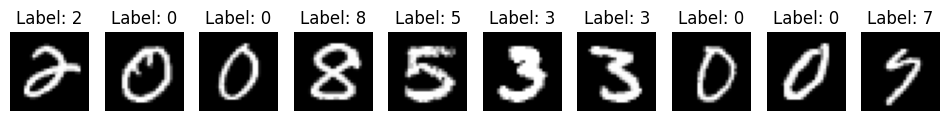

In [32]:
# Function should input the dataloader, and show random 10 images and their labels as title to plot
def show_imgs(train_loader):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    fig, axs = plt.subplots(1, 10, figsize=(12, 12))
    for i in range(10):
        axs[i].imshow(images[i].squeeze(), cmap='gray')
        axs[i].set_title(f"Label: {labels[i].item()}")
        axs[i].axis('off')
    plt.show()
show_imgs(train_loader)

## **2. Utility Functions**

Please complete `train()` and `plot_learning_curves()` functions. `test_accuracy()` has already been provided to you.

In [4]:
def test_accuracy(model, test_loader, input_size, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            images = images.view(-1, input_size)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: %d %%' % (100 * correct / total))


## **2.1 Train Function**
Please refer to the train function in `MNIST_Classifier.ipynb` to complete this function.
- You will need to store the loss and accuracies per iteration (to plot later). Do this for both the train set and test set!
- Please print the loss, accuracy and time taken **each epoch** for both train and test sets

In [5]:
def train(model, loss_fn, optimizer, train_loader, test_loader, batch_size, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    steps = len(train_loader)

    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      tempLoss = 0.0
      correct = 0
      total = 0
      start_time = time.time()

      for batch_idx, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          inputs = inputs.view(-1, 784)


          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          tempLoss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

          #every 100 steps
          if (batch_idx + 1) % 100 == 0:
              val_loss, val_acc = validate(model, test_loader, loss_fn, device)
              print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{steps}], Train Loss: {tempLoss/100:.4f}, Val Loss: { val_loss:.4f}')
              train_losses.append(tempLoss / 100)
              val_losses.append(val_loss)
              tempLoss = 0.0
      #per epoch
      train_accuracies.append(100 * correct / total)
      train_acc = 100.0 * correct / total
      val_loss, val_acc = validate(model, test_loader, loss_fn, device)
      duration = time.time() - start_time
      val_accuracies.append(val_acc)

      print(f'Epoch [{epoch+1}/{num_epochs}] End. Duration: {duration:.2f} seconds. '
              f'Train Acc: {train_acc/100:.4f}, Val Acc: {val_acc/100:.4f}\n')

    return train_losses, train_accuracies, val_losses, val_accuracies

def validate(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.view(-1,784))
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return test_loss / len(test_loader), 100.0 * correct / total

## **2.2 Plot Learning Curves Function**
Plot the loss and accuracies from training. Example outputs will be provided in lab walkthrough.

In [6]:
def plot_learning_curve(train_losses, train_accuracies, val_losses=None, val_accuracies=None):

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))  # Adjust figure size
    x_values = np.arange(0, len(train_losses) * 100, 100)
    # Plot training loss
    plt.plot(x_values, train_losses, label='Train Loss', color='blue')
    plt.plot(x_values, val_losses, label='Val Loss', color='red')
    plt.xticks(x_values[::10], x_values[::10])


    #plt.xticks(x, [str(i * 100) for i in x])

    plt.ylim(0, 1)
    plt.title('Loss vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.legend()
    plt.grid(True)
    plt.show()

# **3. Define CNNs**

A 1-Layer Architecture is already defined for you (`Net`) as a reference. Please complete the definitions of the 2-Layer CNN (`Net2`). The network architecture definitions are provided to you. You must calculate some dimensions yourself.

**NOTE:** For now, please use ReLU activation. You will experiment with other activations in Section 5.

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## **3.1 Create a 2-Layer CNN**
Complete `Net2` class.

 Network Architecture:
* ***Layer 1 (Input)***: Convolutional; input channel = 1, output channel = 20, kernel size = 3, step size = 1.
* ***Layer 2 (Output)***: Fully connected; input dimension = < you find out >, output dimension = < you find out >.

In [8]:
# Define 2-Layer Network
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(13520, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.conv1(x)
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out



class Net2tan(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2tan, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1)
        self.Tanh = nn.Tanh()
        self.fc1 = nn.Linear(13520, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.conv1(x)
        out = self.Tanh(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.Tanh(out)
        out = self.fc2(out)
        return out


# **4. Train and Evaluate**

## **4.1 Training and Evaluating 1-Layer CNN**

Here, you must test your utility functions (`train()` and `plot_learning_curves()`)with the 1-Layer Model. Please at this stage ensure your utility functions are working correctly. The TAs will provide sample outputs in lab walkthrough.

**NOTE**: You can repeatedly use this below code block in Section 5 to run experiments, while making changes to the hyperparameters as required.

In [9]:
def run_experiment(model, learning_rate, batch_size, optimizer_class):
    # Instantiate Model

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


    input_size = 784
    num_classes = 10
    lr = learning_rate
    num_epochs = 5

    net = model(input_size, num_classes)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer_class(net.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Train ModelS
    train_losses,train_accuracies,val_losses, val_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device)

    # Plot Learning Curves
    plot_learning_curve(train_losses, train_accuracies, val_losses, val_accuracies)

    # Evaluate on Test Set
    #test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

## **4.2 Training and Evaluating 2-Layer CNN**


Please also train your 2-Layer network to ensure it is working properly.

Epoch [1/5], Step [100/1875], Train Loss: 3.0564, Val Loss: 0.4898
Epoch [1/5], Step [200/1875], Train Loss: 0.3966, Val Loss: 0.3651
Epoch [1/5], Step [300/1875], Train Loss: 0.2868, Val Loss: 0.2482
Epoch [1/5], Step [400/1875], Train Loss: 0.2228, Val Loss: 0.1970
Epoch [1/5], Step [500/1875], Train Loss: 0.1814, Val Loss: 0.1590
Epoch [1/5], Step [600/1875], Train Loss: 0.1538, Val Loss: 0.1686
Epoch [1/5], Step [700/1875], Train Loss: 0.1829, Val Loss: 0.1467
Epoch [1/5], Step [800/1875], Train Loss: 0.1799, Val Loss: 0.1321
Epoch [1/5], Step [900/1875], Train Loss: 0.1529, Val Loss: 0.1086
Epoch [1/5], Step [1000/1875], Train Loss: 0.1537, Val Loss: 0.1153
Epoch [1/5], Step [1100/1875], Train Loss: 0.1433, Val Loss: 0.1283
Epoch [1/5], Step [1200/1875], Train Loss: 0.1353, Val Loss: 0.1230
Epoch [1/5], Step [1300/1875], Train Loss: 0.1405, Val Loss: 0.1169
Epoch [1/5], Step [1400/1875], Train Loss: 0.1211, Val Loss: 0.1033
Epoch [1/5], Step [1500/1875], Train Loss: 0.1434, Val Lo

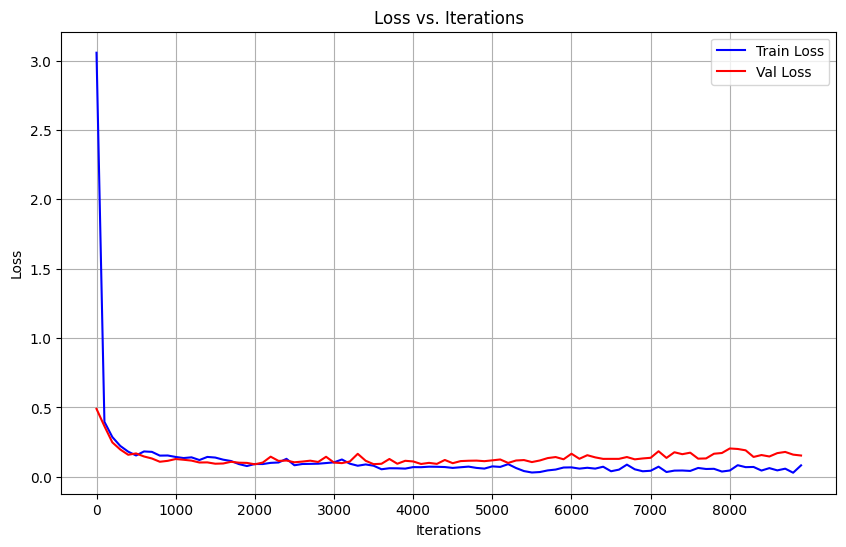

Accuracy: 96 %


In [ ]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses,train_accuracies,val_losses, val_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device)


# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device = device)

# **5. Experiments and Reporting**

In this section, you'll use the utility functions and model definitions from earlier to test various scenarios. You'll modify hyperparameters, run training, plot results, and analyze performance. Based on your observations, you'll answer specific questions.

Use the provided loss, accuracy, and learning curves to address the report questions for each subsection.

**Note:** You will primarily reuse functions from earlier sections. Make any necessary code changes in the sections marked `# YOUR CODE HERE`.

## **5.1 Learning Curves**

### **❓ Q 5.1.1 What is a Learning curve and why is it useful? You can refer to learning curves you have plotted in Section 4.** (you do not need to run any codes here)

A Learning curve is a plot of a model's performance over time, showing validation vs training. This plot can be useful to determine the best hyperparameters to minimize loss most efficiently. For example, in 4.2 the train loss keeps decreasing and val loss is increasing. This is indicative of overfitting, meaning the model keeps learning but is not improving at guessing to generalized data.


---

### **5.2 Learning Rates**

Please plot the curves for three separate training instances with learning rates of: `2e-3`, `3e-4`, `5e-2 `

Use the 2-Layer CNN.

Learning rate: 0.002
Epoch [1/5], Step [100/1875], Train Loss: 1.1560, Val Loss: 0.3989
Epoch [1/5], Step [200/1875], Train Loss: 0.3902, Val Loss: 0.3402
Epoch [1/5], Step [300/1875], Train Loss: 0.3094, Val Loss: 0.2191
Epoch [1/5], Step [400/1875], Train Loss: 0.2405, Val Loss: 0.2277
Epoch [1/5], Step [500/1875], Train Loss: 0.1977, Val Loss: 0.1851
Epoch [1/5], Step [600/1875], Train Loss: 0.1841, Val Loss: 0.1316
Epoch [1/5], Step [700/1875], Train Loss: 0.1639, Val Loss: 0.1270
Epoch [1/5], Step [800/1875], Train Loss: 0.1357, Val Loss: 0.1280
Epoch [1/5], Step [900/1875], Train Loss: 0.1361, Val Loss: 0.1375
Epoch [1/5], Step [1000/1875], Train Loss: 0.1202, Val Loss: 0.0883
Epoch [1/5], Step [1100/1875], Train Loss: 0.1194, Val Loss: 0.1038
Epoch [1/5], Step [1200/1875], Train Loss: 0.1009, Val Loss: 0.0825
Epoch [1/5], Step [1300/1875], Train Loss: 0.1022, Val Loss: 0.0917
Epoch [1/5], Step [1400/1875], Train Loss: 0.0916, Val Loss: 0.0818
Epoch [1/5], Step [1500/1875], Train

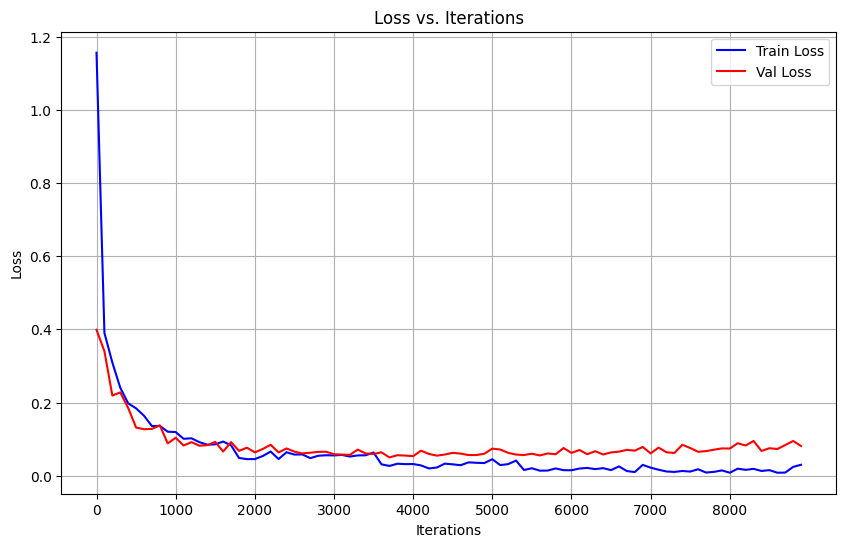

Accuracy: 96 %


In [ ]:
# 2e-3
learning_rate = 0.002
batch_size = 32
optimizer_class = torch.optim.Adam
print(f"Learning rate: {learning_rate}")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

Learning rate: 0.0003
Epoch [1/5], Step [100/1875], Train Loss: 0.9579, Val Loss: 0.4134
Epoch [1/5], Step [200/1875], Train Loss: 0.3823, Val Loss: 0.3150
Epoch [1/5], Step [300/1875], Train Loss: 0.3121, Val Loss: 0.2657
Epoch [1/5], Step [400/1875], Train Loss: 0.2772, Val Loss: 0.2349
Epoch [1/5], Step [500/1875], Train Loss: 0.2259, Val Loss: 0.2297
Epoch [1/5], Step [600/1875], Train Loss: 0.2170, Val Loss: 0.1957
Epoch [1/5], Step [700/1875], Train Loss: 0.1999, Val Loss: 0.1867
Epoch [1/5], Step [800/1875], Train Loss: 0.1912, Val Loss: 0.1686
Epoch [1/5], Step [900/1875], Train Loss: 0.1603, Val Loss: 0.1489
Epoch [1/5], Step [1000/1875], Train Loss: 0.1553, Val Loss: 0.1620
Epoch [1/5], Step [1100/1875], Train Loss: 0.1483, Val Loss: 0.1519
Epoch [1/5], Step [1200/1875], Train Loss: 0.1428, Val Loss: 0.1283
Epoch [1/5], Step [1300/1875], Train Loss: 0.1407, Val Loss: 0.1207
Epoch [1/5], Step [1400/1875], Train Loss: 0.1466, Val Loss: 0.1088
Epoch [1/5], Step [1500/1875], Trai

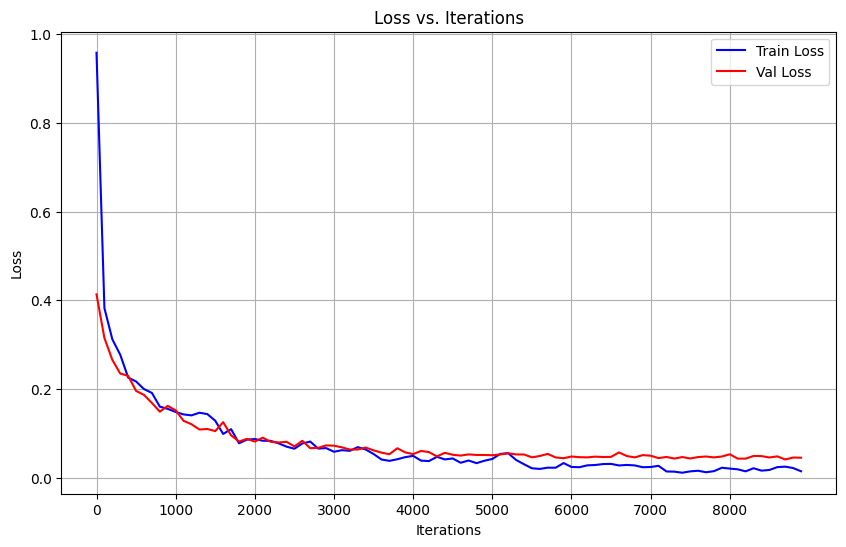

Accuracy: 96 %


In [ ]:
# 3e-4
learning_rate = 0.0003
print(f"Learning rate: {learning_rate}")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

Learning rate: 0.05
Epoch [1/5], Step [100/1875], Train Loss: 14.4115, Val Loss: 2.3051
Epoch [1/5], Step [200/1875], Train Loss: 2.3077, Val Loss: 2.3053
Epoch [1/5], Step [300/1875], Train Loss: 2.3075, Val Loss: 2.3083
Epoch [1/5], Step [400/1875], Train Loss: 2.3060, Val Loss: 2.3074
Epoch [1/5], Step [500/1875], Train Loss: 2.3047, Val Loss: 2.3082
Epoch [1/5], Step [600/1875], Train Loss: 2.3072, Val Loss: 2.3055
Epoch [1/5], Step [700/1875], Train Loss: 2.3073, Val Loss: 2.3052
Epoch [1/5], Step [800/1875], Train Loss: 2.3069, Val Loss: 2.3042
Epoch [1/5], Step [900/1875], Train Loss: 2.3067, Val Loss: 2.3065
Epoch [1/5], Step [1000/1875], Train Loss: 2.3056, Val Loss: 2.3108
Epoch [1/5], Step [1100/1875], Train Loss: 2.3063, Val Loss: 2.3100
Epoch [1/5], Step [1200/1875], Train Loss: 2.3064, Val Loss: 2.3181
Epoch [1/5], Step [1300/1875], Train Loss: 2.3064, Val Loss: 2.3072
Epoch [1/5], Step [1400/1875], Train Loss: 2.3087, Val Loss: 2.3069
Epoch [1/5], Step [1500/1875], Train

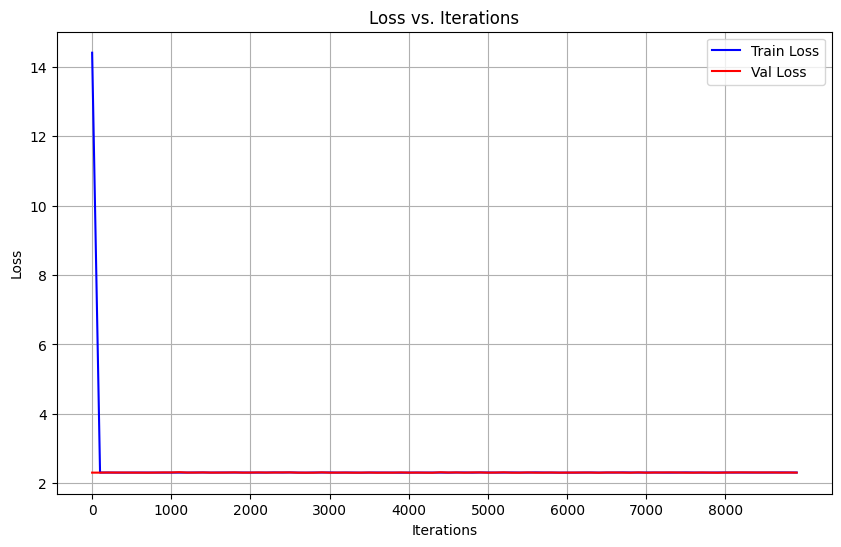

In [ ]:
# 5e-2
learning_rate = 0.05
print(f"Learning rate: {learning_rate}")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

### ❓ **Q 5.2.1 For each learning rate, explain if the model is underfitting, overfitting, or is training well. Explain the difference between high learning rates and low learning rates in terms of the optimization process.**

1) A learning rate of 2e-3 results in slight overfitting. In the graph, initially the model settles at a good loss value but quickly the training loss decreases much lower than the validation loss, indicating lack of generalization and overfitting.

2) A rate of 3e-4 trains the model well. Both the validation and training loss approach a low loss while staying relatively close together, indicating the model is not under or over fitting.

3) A rate of 5e-2 is much to high, leading to underfitting. The model is unstable and fails to converge even under 1.0, converging at about 2.0 and its accuracy hovering at 10% meaning the model has little to no ability to generalize.


A high learning rate readjusts the weight more frequently allowing the model to quickly make changes but it is suseptible to overshooting the ideal because of its large corrections. A low learning rate makes smaller update to the model's weights, meaning it will take longer to reduce loss however the smaller changes to weight make it more stable.

---

### **5.3 Optimizer**
The optimizer we have used before is Adam. Change the optimizer to:
- **Stochastic gradient descent ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))**
- **SGD with momentum:** try momentum 0.5 and 0.9.

Use 2-Layer CNN. Keep all other hyperparameters constant. You can use the best from earlier experiments.

Running experiment with SGD
Epoch [1/5], Step [100/1875], Train Loss: 2.2992, Val Loss: 2.2943
Epoch [1/5], Step [200/1875], Train Loss: 2.2893, Val Loss: 2.2847
Epoch [1/5], Step [300/1875], Train Loss: 2.2810, Val Loss: 2.2755
Epoch [1/5], Step [400/1875], Train Loss: 2.2723, Val Loss: 2.2669
Epoch [1/5], Step [500/1875], Train Loss: 2.2622, Val Loss: 2.2584
Epoch [1/5], Step [600/1875], Train Loss: 2.2563, Val Loss: 2.2498
Epoch [1/5], Step [700/1875], Train Loss: 2.2489, Val Loss: 2.2413
Epoch [1/5], Step [800/1875], Train Loss: 2.2387, Val Loss: 2.2322
Epoch [1/5], Step [900/1875], Train Loss: 2.2296, Val Loss: 2.2230
Epoch [1/5], Step [1000/1875], Train Loss: 2.2234, Val Loss: 2.2135
Epoch [1/5], Step [1100/1875], Train Loss: 2.2115, Val Loss: 2.2037
Epoch [1/5], Step [1200/1875], Train Loss: 2.2023, Val Loss: 2.1935
Epoch [1/5], Step [1300/1875], Train Loss: 2.1892, Val Loss: 2.1826
Epoch [1/5], Step [1400/1875], Train Loss: 2.1802, Val Loss: 2.1715
Epoch [1/5], Step [1500/1875]

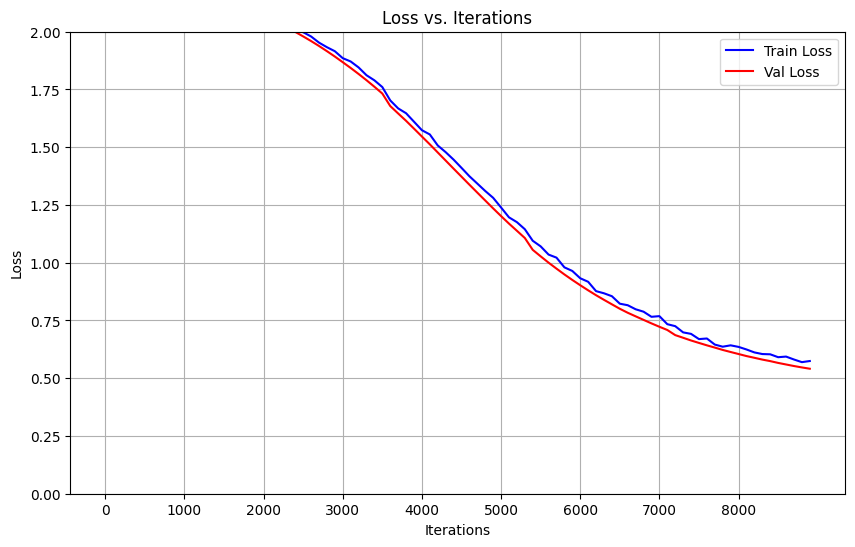

In [ ]:
# SGD
learning_rate = 0.0003
batch_size = 32
optimizer_class = torch.optim.SGD
print(f"Running experiment with SGD")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

Running experiment with SGD and 0.5 momentum
Epoch [1/5], Step [100/1875], Train Loss: 2.2943, Val Loss: 2.2857
Epoch [1/5], Step [200/1875], Train Loss: 2.2788, Val Loss: 2.2695
Epoch [1/5], Step [300/1875], Train Loss: 2.2628, Val Loss: 2.2534
Epoch [1/5], Step [400/1875], Train Loss: 2.2463, Val Loss: 2.2366
Epoch [1/5], Step [500/1875], Train Loss: 2.2298, Val Loss: 2.2187
Epoch [1/5], Step [600/1875], Train Loss: 2.2081, Val Loss: 2.1987
Epoch [1/5], Step [700/1875], Train Loss: 2.1901, Val Loss: 2.1768
Epoch [1/5], Step [800/1875], Train Loss: 2.1684, Val Loss: 2.1525
Epoch [1/5], Step [900/1875], Train Loss: 2.1440, Val Loss: 2.1254
Epoch [1/5], Step [1000/1875], Train Loss: 2.1194, Val Loss: 2.0960
Epoch [1/5], Step [1100/1875], Train Loss: 2.0821, Val Loss: 2.0621
Epoch [1/5], Step [1200/1875], Train Loss: 2.0467, Val Loss: 2.0239
Epoch [1/5], Step [1300/1875], Train Loss: 2.0113, Val Loss: 1.9818
Epoch [1/5], Step [1400/1875], Train Loss: 1.9645, Val Loss: 1.9346
Epoch [1/5],

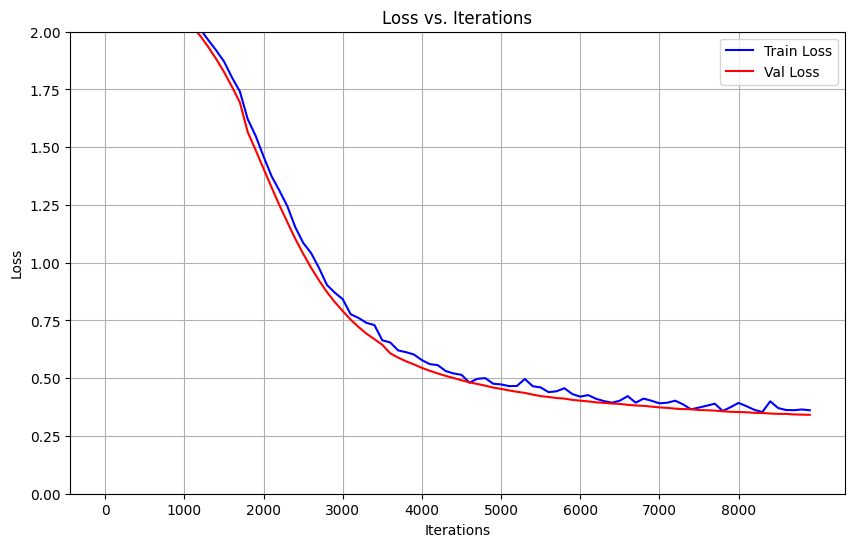

In [ ]:
# SGD 0.5
optimizer_class = lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.5)
print(f"Running experiment with SGD and 0.5 momentum")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

Running experiment with SGD and 0.9 momentum
Epoch [1/5], Step [100/1875], Train Loss: 2.2326, Val Loss: 2.1398
Epoch [1/5], Step [200/1875], Train Loss: 2.0275, Val Loss: 1.8871
Epoch [1/5], Step [300/1875], Train Loss: 1.7205, Val Loss: 1.5219
Epoch [1/5], Step [400/1875], Train Loss: 1.3448, Val Loss: 1.1250
Epoch [1/5], Step [500/1875], Train Loss: 0.9982, Val Loss: 0.8399
Epoch [1/5], Step [600/1875], Train Loss: 0.7784, Val Loss: 0.6721
Epoch [1/5], Step [700/1875], Train Loss: 0.6250, Val Loss: 0.5748
Epoch [1/5], Step [800/1875], Train Loss: 0.5774, Val Loss: 0.5120
Epoch [1/5], Step [900/1875], Train Loss: 0.5191, Val Loss: 0.4709
Epoch [1/5], Step [1000/1875], Train Loss: 0.4639, Val Loss: 0.4371
Epoch [1/5], Step [1100/1875], Train Loss: 0.4513, Val Loss: 0.4175
Epoch [1/5], Step [1200/1875], Train Loss: 0.4332, Val Loss: 0.3940
Epoch [1/5], Step [1300/1875], Train Loss: 0.4096, Val Loss: 0.3864
Epoch [1/5], Step [1400/1875], Train Loss: 0.4241, Val Loss: 0.3713
Epoch [1/5],

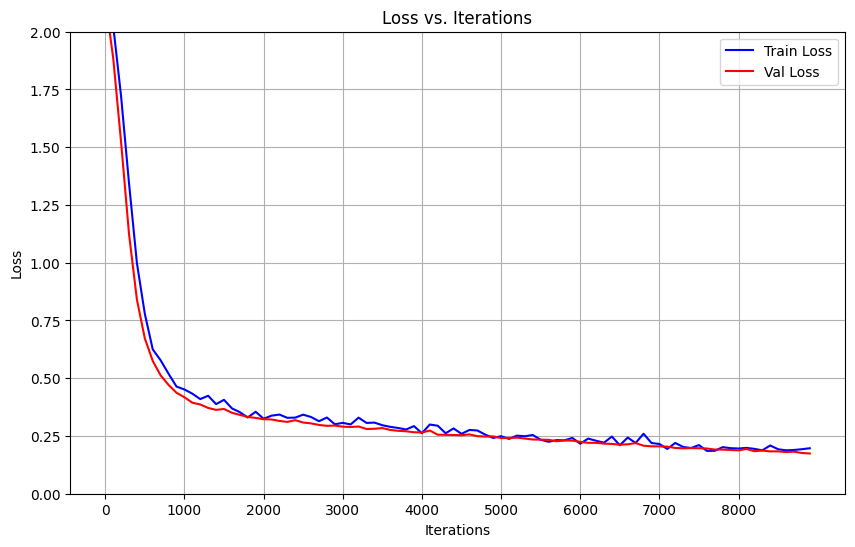

In [ ]:
# SGD 0.9
optimizer_class = lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9)
print(f"Running experiment with SGD and 0.9 momentum")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

 ❓ **Q 5.3.1 Explain the differences in Adam and both SGD optimizations. Compare the results of each optimizer based on the learning curves.**

Adam seems to converge more quickly to a stable loss but SGD converges slower. However, SGD's validation loss curve is extremely smooth and has almost no noisy variations. It seems Adam is better suited for this project as its accuracy is significantly better than any of the SGD optimizations.

The first SGD optimization takes extremely long to converge and does not generalize well. The second does better and gets close to 90% accuracy. The last with a value of .9 for momentum converges the quickest and has has almost no noise in its validation loss.

---

### **5.4 Initializing Weights**

Initialize the weights to:
- all zeros
- all ones
- all randomly initialized with a normal distribution.

Use 2-Layer CNN.

Running experiment with all zeroes
Epoch [1/5], Step [100/1875], Train Loss: 0.8724, Val Loss: 0.4527
Epoch [1/5], Step [200/1875], Train Loss: 0.4179, Val Loss: 0.3313
Epoch [1/5], Step [300/1875], Train Loss: 0.3279, Val Loss: 0.2814
Epoch [1/5], Step [400/1875], Train Loss: 0.2870, Val Loss: 0.2395
Epoch [1/5], Step [500/1875], Train Loss: 0.2609, Val Loss: 0.2329
Epoch [1/5], Step [600/1875], Train Loss: 0.2373, Val Loss: 0.2080
Epoch [1/5], Step [700/1875], Train Loss: 0.2272, Val Loss: 0.1857
Epoch [1/5], Step [800/1875], Train Loss: 0.2007, Val Loss: 0.1827
Epoch [1/5], Step [900/1875], Train Loss: 0.1934, Val Loss: 0.1496
Epoch [1/5], Step [1000/1875], Train Loss: 0.1741, Val Loss: 0.1409
Epoch [1/5], Step [1100/1875], Train Loss: 0.1377, Val Loss: 0.1428
Epoch [1/5], Step [1200/1875], Train Loss: 0.1774, Val Loss: 0.1419
Epoch [1/5], Step [1300/1875], Train Loss: 0.1387, Val Loss: 0.1324
Epoch [1/5], Step [1400/1875], Train Loss: 0.1590, Val Loss: 0.1162
Epoch [1/5], Step [150

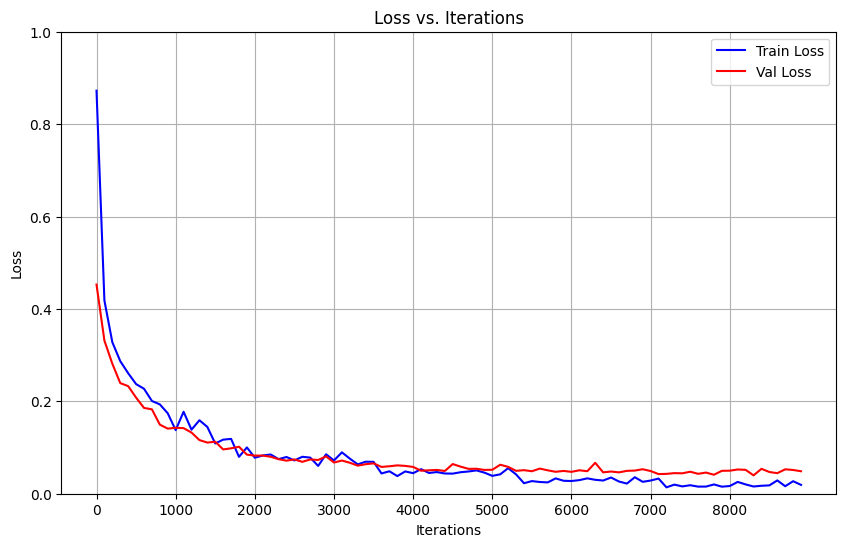

In [ ]:
# All zeros
def init_weights_zero(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.zeros_(m.weight)
        nn.init.zeros_(m.bias)
learning_rate = 0.0003
batch_size = 32
optimizer_class = torch.optim.Adam
model = Net2(input_size, num_classes).to(device)
model.apply(init_weights_zero)
print(f"Running experiment with all zeroes")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

Running experiment with all ones
Epoch [1/5], Step [100/1875], Train Loss: 1.0870, Val Loss: 0.5077
Epoch [1/5], Step [200/1875], Train Loss: 0.3932, Val Loss: 0.3338
Epoch [1/5], Step [300/1875], Train Loss: 0.3324, Val Loss: 0.2772
Epoch [1/5], Step [400/1875], Train Loss: 0.2827, Val Loss: 0.2359
Epoch [1/5], Step [500/1875], Train Loss: 0.2636, Val Loss: 0.2426
Epoch [1/5], Step [600/1875], Train Loss: 0.2271, Val Loss: 0.2092
Epoch [1/5], Step [700/1875], Train Loss: 0.2259, Val Loss: 0.1974
Epoch [1/5], Step [800/1875], Train Loss: 0.2056, Val Loss: 0.1663
Epoch [1/5], Step [900/1875], Train Loss: 0.1692, Val Loss: 0.1532
Epoch [1/5], Step [1000/1875], Train Loss: 0.1678, Val Loss: 0.1457
Epoch [1/5], Step [1100/1875], Train Loss: 0.1658, Val Loss: 0.1442
Epoch [1/5], Step [1200/1875], Train Loss: 0.1436, Val Loss: 0.1318
Epoch [1/5], Step [1300/1875], Train Loss: 0.1423, Val Loss: 0.1352
Epoch [1/5], Step [1400/1875], Train Loss: 0.1370, Val Loss: 0.1238
Epoch [1/5], Step [1500/

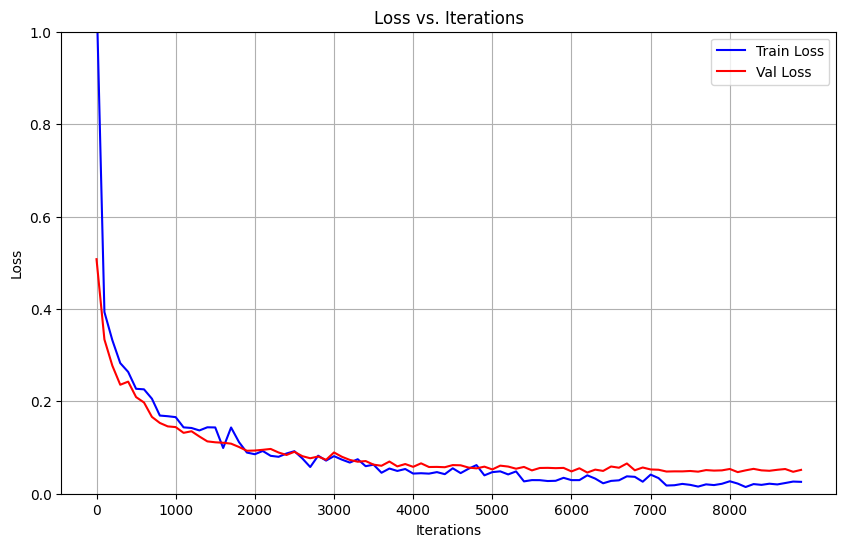

In [ ]:
# All ones
def init_weights_ones(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.ones_(m.weight)
        nn.init.ones_(m.bias)

learning_rate = 0.0003
batch_size = 32
optimizer_class = torch.optim.Adam
model = Net2(input_size, num_classes).to(device)

model.apply(init_weights_ones)
print(f"Running experiment with all ones")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

Running experiment with random weights
Epoch [1/5], Step [100/1875], Train Loss: 0.9991, Val Loss: 0.4597
Epoch [1/5], Step [200/1875], Train Loss: 0.4149, Val Loss: 0.3255
Epoch [1/5], Step [300/1875], Train Loss: 0.3557, Val Loss: 0.3198
Epoch [1/5], Step [400/1875], Train Loss: 0.2994, Val Loss: 0.2729
Epoch [1/5], Step [500/1875], Train Loss: 0.2954, Val Loss: 0.2566
Epoch [1/5], Step [600/1875], Train Loss: 0.2602, Val Loss: 0.2159
Epoch [1/5], Step [700/1875], Train Loss: 0.2431, Val Loss: 0.2174
Epoch [1/5], Step [800/1875], Train Loss: 0.2217, Val Loss: 0.1952
Epoch [1/5], Step [900/1875], Train Loss: 0.1848, Val Loss: 0.1872
Epoch [1/5], Step [1000/1875], Train Loss: 0.1935, Val Loss: 0.1962
Epoch [1/5], Step [1100/1875], Train Loss: 0.1792, Val Loss: 0.1553
Epoch [1/5], Step [1200/1875], Train Loss: 0.1807, Val Loss: 0.1502
Epoch [1/5], Step [1300/1875], Train Loss: 0.1380, Val Loss: 0.1556
Epoch [1/5], Step [1400/1875], Train Loss: 0.1555, Val Loss: 0.1282
Epoch [1/5], Step 

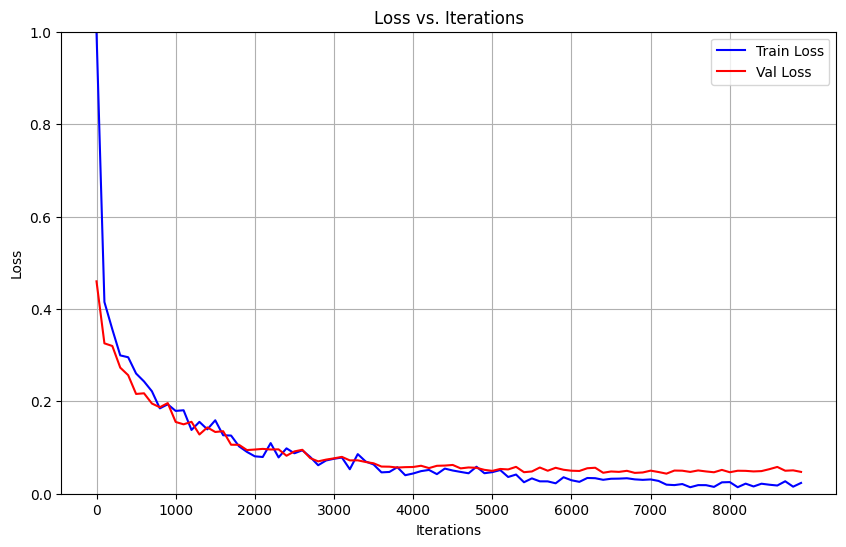

In [ ]:
# Random
def init_weights_random(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight)
        nn.init.normal_(m.bias)

learning_rate = 0.0003
batch_size = 32
optimizer_class = torch.optim.Adam

model = Net2(input_size, num_classes).to(device)
model.apply(init_weights_random)
print(f"Running experiment with random weights")
run_experiment(Net2, learning_rate, batch_size, optimizer_class)

#### ❓ **Q 5.4.1 How is the training process affected when we initialize our network weights differently? Based on what you observe, give a recommendation as to how weights should be initialized. Explain your reasoning.**

(Note: your results may not reflect what is expected. Please explain what is expected and why your results may not reflect that.)

The training process using all ones or all zeros should result in a slower convergence because they are symetrical. Random number generation would break this symmetry and maximizize each nerouns ability to learn different features.

Our results do not reflect what is expected as the all zeros model seems to be as efficient as random.

What should be done however is initialized using random weights, as it created variation among the neourons in a layer and avoid symmetry like all ones or all zeros.

---

### **5.5 Activation Function**

Please change the `relu` function in the example code to a `tanh` function.

Use 2-Layer CNN. Keep all other hyperparameters constant. You can use the best from earlier experiments.

Running experiment with tanh
Epoch [1/5], Step [100/1875], Train Loss: 0.8943, Val Loss: 0.4765
Epoch [1/5], Step [200/1875], Train Loss: 0.4227, Val Loss: 0.3965
Epoch [1/5], Step [300/1875], Train Loss: 0.3733, Val Loss: 0.3227
Epoch [1/5], Step [400/1875], Train Loss: 0.3382, Val Loss: 0.3037
Epoch [1/5], Step [500/1875], Train Loss: 0.2918, Val Loss: 0.2754
Epoch [1/5], Step [600/1875], Train Loss: 0.2792, Val Loss: 0.2520
Epoch [1/5], Step [700/1875], Train Loss: 0.2206, Val Loss: 0.2213
Epoch [1/5], Step [800/1875], Train Loss: 0.2243, Val Loss: 0.2076
Epoch [1/5], Step [900/1875], Train Loss: 0.2189, Val Loss: 0.2047
Epoch [1/5], Step [1000/1875], Train Loss: 0.1975, Val Loss: 0.1795
Epoch [1/5], Step [1100/1875], Train Loss: 0.1723, Val Loss: 0.1746
Epoch [1/5], Step [1200/1875], Train Loss: 0.1888, Val Loss: 0.1815
Epoch [1/5], Step [1300/1875], Train Loss: 0.2021, Val Loss: 0.1639
Epoch [1/5], Step [1400/1875], Train Loss: 0.1792, Val Loss: 0.1658
Epoch [1/5], Step [1500/1875

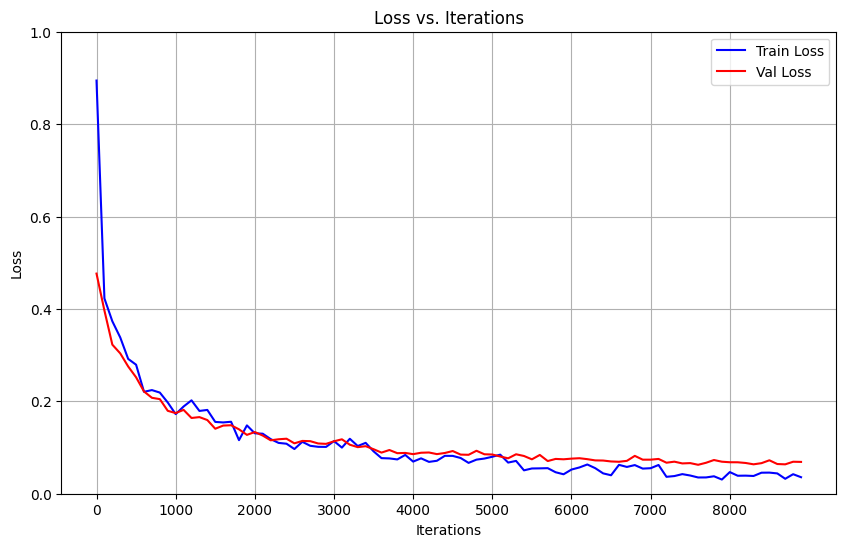

In [ ]:
# YOUR CODE HERE
learning_rate = 0.0003
batch_size = 32
optimizer_class = torch.optim.Adam

model = Net2(input_size, num_classes).to(device)
model.apply(init_weights_random)
print(f"Running experiment with tanh")
run_experiment(Net2tan, learning_rate, batch_size, optimizer_class)

#### ❓ **Q 5.5.1 How does changing the activation function to tanh affect the performance? Is it better or worse? Explain why.**

Changing to tanh leads to a slower convergence but reduces noise in the beginning of the training. It relies on output values from [-1,1] so it remains more balanced during backpropagation. The downside of tanh is that if the inputs are really large or small it struggles and loses to relu later in learning as seen near 6000 iterations above.

---

### **5.6 Batch Size**

Test training using different batch sizes to compare. Please use batch size of:
- 8
- 64
- 128

Use 2-Layer CNN. Keep all other hyperparameters constant. You can use the best from earlier experiments.

Running experiment with batch size 8
Epoch [1/1], Step [100/7500], Train Loss: 1.6028, Val Loss: 0.8440
Epoch [1/1], Step [200/7500], Train Loss: 0.5800, Val Loss: 0.5170
Epoch [1/1], Step [300/7500], Train Loss: 0.5288, Val Loss: 0.3908
Epoch [1/1], Step [400/7500], Train Loss: 0.4137, Val Loss: 0.3591
Epoch [1/1], Step [500/7500], Train Loss: 0.3133, Val Loss: 0.3819
Epoch [1/1], Step [600/7500], Train Loss: 0.3920, Val Loss: 0.4608
Epoch [1/1], Step [700/7500], Train Loss: 0.3588, Val Loss: 0.4104
Epoch [1/1], Step [800/7500], Train Loss: 0.3787, Val Loss: 0.3235
Epoch [1/1], Step [900/7500], Train Loss: 0.2938, Val Loss: 0.2956
Epoch [1/1], Step [1000/7500], Train Loss: 0.3586, Val Loss: 0.2981
Epoch [1/1], Step [1100/7500], Train Loss: 0.2871, Val Loss: 0.2549
Epoch [1/1], Step [1200/7500], Train Loss: 0.3438, Val Loss: 0.2646
Epoch [1/1], Step [1300/7500], Train Loss: 0.3076, Val Loss: 0.2344
Epoch [1/1], Step [1400/7500], Train Loss: 0.2156, Val Loss: 0.2557
Epoch [1/1], Step [1

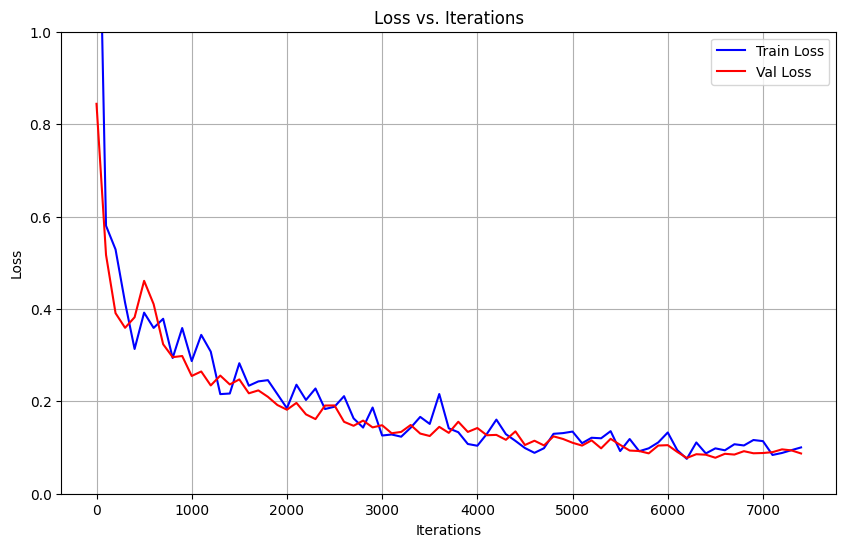

In [ ]:
# Batch size 8
#This one was taking forever so I used 1 epoch
learning_rate = 0.0003
batch_size = 8
optimizer_class = torch.optim.Adam

model = Net2(input_size, num_classes).to(device)
model.apply(init_weights_random)

print(f"Running experiment with batch size {batch_size}")
run_experiment(Net2, learning_rate, batch_size, torch.optim.Adam)

Running experiment with batch size 64
Epoch [1/5], Step [100/938], Train Loss: 0.8340, Val Loss: 0.3714
Epoch [1/5], Step [200/938], Train Loss: 0.3386, Val Loss: 0.2861
Epoch [1/5], Step [300/938], Train Loss: 0.2687, Val Loss: 0.2559
Epoch [1/5], Step [400/938], Train Loss: 0.2266, Val Loss: 0.1968
Epoch [1/5], Step [500/938], Train Loss: 0.2121, Val Loss: 0.1792
Epoch [1/5], Step [600/938], Train Loss: 0.1857, Val Loss: 0.1688
Epoch [1/5], Step [700/938], Train Loss: 0.1632, Val Loss: 0.1392
Epoch [1/5], Step [800/938], Train Loss: 0.1491, Val Loss: 0.1196
Epoch [1/5], Step [900/938], Train Loss: 0.1348, Val Loss: 0.1252
Epoch [1/5] End. Duration: 23.37 seconds. Train Acc: 0.9221, Val Acc: 0.9704

Epoch [2/5], Step [100/938], Train Loss: 0.0961, Val Loss: 0.1028
Epoch [2/5], Step [200/938], Train Loss: 0.0989, Val Loss: 0.0978
Epoch [2/5], Step [300/938], Train Loss: 0.0899, Val Loss: 0.0887
Epoch [2/5], Step [400/938], Train Loss: 0.0935, Val Loss: 0.0947
Epoch [2/5], Step [500/938

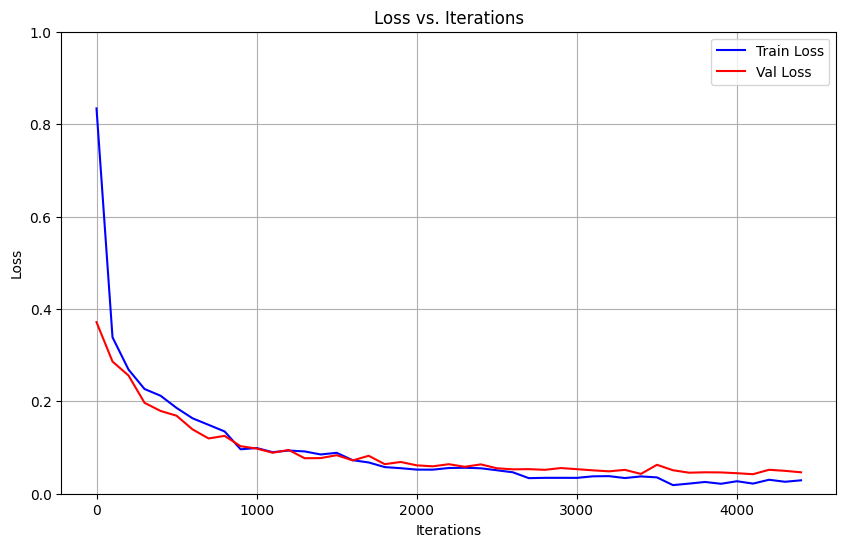

In [ ]:
# Batch size 64
batch_size = 64
print(f"Running experiment with batch size {batch_size}")
run_experiment(Net2, learning_rate, batch_size, torch.optim.Adam)

Running experiment with batch size 128
Epoch [1/5], Step [100/469], Train Loss: 0.8103, Val Loss: 0.3968
Epoch [1/5], Step [200/469], Train Loss: 0.3278, Val Loss: 0.2660
Epoch [1/5], Step [300/469], Train Loss: 0.2691, Val Loss: 0.2356
Epoch [1/5], Step [400/469], Train Loss: 0.2269, Val Loss: 0.2148
Epoch [1/5] End. Duration: 16.14 seconds. Train Acc: 0.8933, Val Acc: 0.9489

Epoch [2/5], Step [100/469], Train Loss: 0.1839, Val Loss: 0.1669
Epoch [2/5], Step [200/469], Train Loss: 0.1648, Val Loss: 0.1500
Epoch [2/5], Step [300/469], Train Loss: 0.1490, Val Loss: 0.1350
Epoch [2/5], Step [400/469], Train Loss: 0.1224, Val Loss: 0.1186
Epoch [2/5] End. Duration: 16.81 seconds. Train Acc: 0.9564, Val Acc: 0.9665

Epoch [3/5], Step [100/469], Train Loss: 0.0995, Val Loss: 0.1044
Epoch [3/5], Step [200/469], Train Loss: 0.0952, Val Loss: 0.0978
Epoch [3/5], Step [300/469], Train Loss: 0.0962, Val Loss: 0.0901
Epoch [3/5], Step [400/469], Train Loss: 0.0964, Val Loss: 0.0891
Epoch [3/5] E

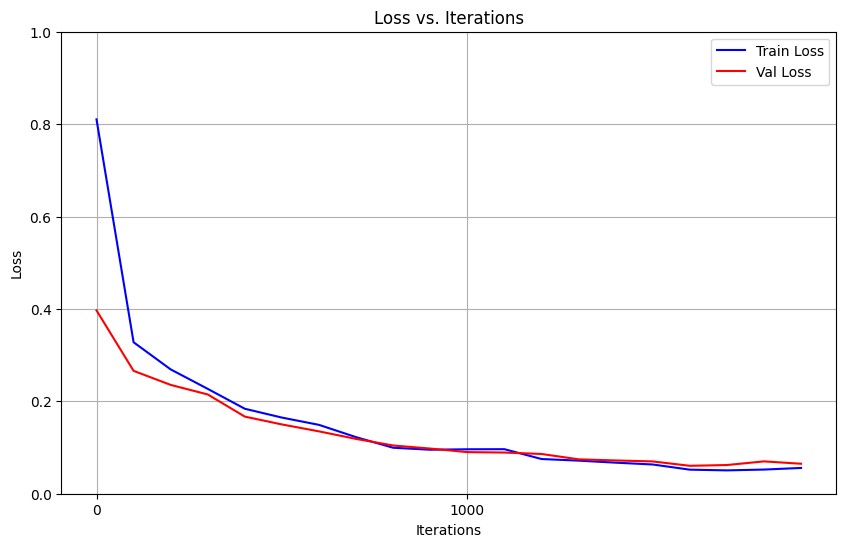

In [ ]:
# Batch size 128
learning_rate = 0.0003
batch_size = 128
print(f"Running experiment with batch size {batch_size}")
run_experiment(Net2, learning_rate, batch_size, torch.optim.Adam)

#### ❓ **Q 5.6.1 How does changing batch size affect the training process?**

A small batch size results in noisy data and in this situation takes a really long time to train. A large batch size may lead to overfitting but in this case it does well, however it requires more computational power. A medium sized batch size like 64 is useful here, which converges quickly and the validation and training graph is close.

---

### 5.7 Different Network Architectures

Please complete the `Net5` and `FCN` definitions. The archtiectures are defined below.


#### **5.7.1 Net5: 5-Layer CNN**
Similar to the 2-Layer model, make a new class ```Net5```.

* ***Layer 1 (Input)***: Convolutional, input channel = 1, output channel = 32, kernel size = 5, stride = 1, padding = 2.
* ***Layer 2 (Hidden 1)***: Pooling, kernel size = 2, stride = 2.
* ***Layer 3 (Hidden 2)***: Convolutional, input channel = < you find out> , output channel = 64, kernel size = 5, stride = 1 padding = 2.
* ***Layer 4 (Hidden 3)***: Fully connected, input channel = < you find out>, output channel = 1024.
* ***Layer 5 (Output)***: Fully connected, input channel = < you find out>, < you find out >

In [13]:
# YOUR CODE HERE (NET5)

#

# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
      super(Net5, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
      self.relu = nn.ReLU()

      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)

      self.fc1 = nn.Linear(in_features=64*14*14, out_features=1024)

      self.fc2 = nn.Linear(in_features=1024, out_features=10)
    def forward(self, x):
      x = x.view(-1, 1, 28, 28)
      out = self.conv1(x)
      out = self.relu(out)

      out = self.pool(out)


      out = self.conv2(out)
      out = self.relu(out)

      out = out.view(out.size(0), -1)

      out = self.fc1(out)
      out = self.relu(out)

      out = self.fc2(out)

      return out

#### **5.7.2 FCN**

Here we will define a Fully Connected Network `FCN` (Not a CNN).

- **Layer 1 (Input):** Size = < you find out >
- **Layer 2 (Hidden 1):** 256 neurons
- **Layer 3 (Hidden 2):** 256 neurons
- **Layer 4 (Output):** Size = < you find out >

In [18]:
# YOUR CODE HERE (FCN)

# ...

# Define FCN
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
      super(FCN, self).__init__()
      self.layer1 = nn.Linear(in_features=784, out_features=256)
      self.relu1 = nn.ReLU()
      self.layer2 = nn.Linear(in_features=256, out_features=256)
      self.relu2 = nn.ReLU()
      self.layer3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):

      x = x.view(-1, 784)
      x = self.relu1(self.layer1(x))
      x = self.relu2(self.layer2(x))
      x = self.layer3(x)

      return x

#### **5.7.3 Training the different architectures**

Train and evaluate `Net2`, `Net5`, and `FCN` using batch size of 64, the best learning rate from Section 5.1, and the best optimizer from Section 5.5


Training Net2
Epoch [1/5], Step [100/938], Train Loss: 0.8461, Val Loss: 0.3965
Epoch [1/5], Step [200/938], Train Loss: 0.3806, Val Loss: 0.3047
Epoch [1/5], Step [300/938], Train Loss: 0.2971, Val Loss: 0.2592
Epoch [1/5], Step [400/938], Train Loss: 0.2302, Val Loss: 0.2259
Epoch [1/5], Step [500/938], Train Loss: 0.2285, Val Loss: 0.1905
Epoch [1/5], Step [600/938], Train Loss: 0.2187, Val Loss: 0.1742
Epoch [1/5], Step [700/938], Train Loss: 0.1911, Val Loss: 0.1670
Epoch [1/5], Step [800/938], Train Loss: 0.1715, Val Loss: 0.1540
Epoch [1/5], Step [900/938], Train Loss: 0.1583, Val Loss: 0.1371
Epoch [1/5] End. Duration: 26.58 seconds. Train Acc: 0.9158, Val Acc: 0.9607

Epoch [2/5], Step [100/938], Train Loss: 0.1296, Val Loss: 0.1155
Epoch [2/5], Step [200/938], Train Loss: 0.1209, Val Loss: 0.1135
Epoch [2/5], Step [300/938], Train Loss: 0.1058, Val Loss: 0.1013
Epoch [2/5], Step [400/938], Train Loss: 0.1180, Val Loss: 0.1094
Epoch [2/5], Step [500/938], Train Loss: 0.1125, V

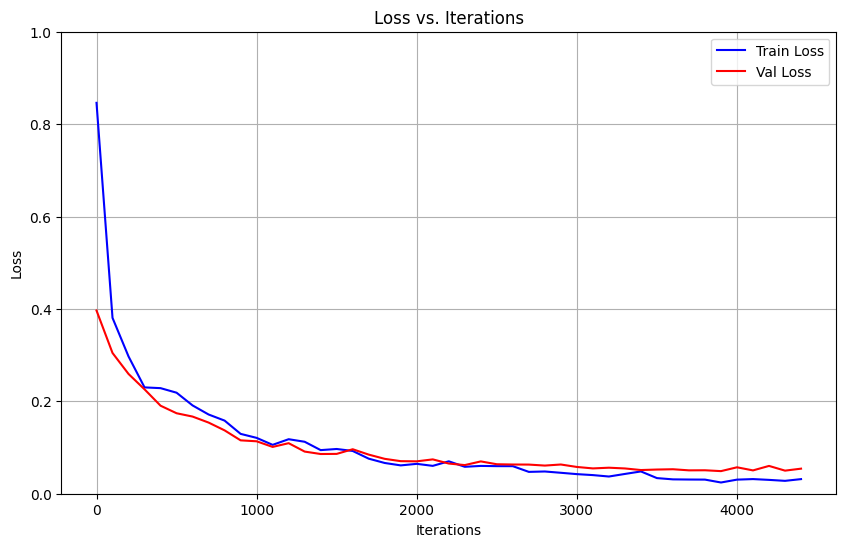

In [11]:
# Net2
best_learning_rate = 0.0003
batch_size = 64
best_optimizer =  torch.optim.Adam
print(f"Training Net2")
run_experiment(Net2, best_learning_rate, batch_size, best_optimizer)

Training Net5
Epoch [1/5], Step [100/938], Train Loss: 0.5675, Val Loss: 0.2437
Epoch [1/5], Step [200/938], Train Loss: 0.1968, Val Loss: 0.1526
Epoch [1/5], Step [300/938], Train Loss: 0.1378, Val Loss: 0.0964
Epoch [1/5], Step [400/938], Train Loss: 0.1094, Val Loss: 0.1116
Epoch [1/5], Step [500/938], Train Loss: 0.0901, Val Loss: 0.0684
Epoch [1/5], Step [600/938], Train Loss: 0.0885, Val Loss: 0.0622
Epoch [1/5], Step [700/938], Train Loss: 0.0868, Val Loss: 0.0524
Epoch [1/5], Step [800/938], Train Loss: 0.0592, Val Loss: 0.0473
Epoch [1/5], Step [900/938], Train Loss: 0.0684, Val Loss: 0.0591
Epoch [1/5] End. Duration: 25.75 seconds. Train Acc: 0.9541, Val Acc: 0.9836

Epoch [2/5], Step [100/938], Train Loss: 0.0523, Val Loss: 0.0461
Epoch [2/5], Step [200/938], Train Loss: 0.0493, Val Loss: 0.0389
Epoch [2/5], Step [300/938], Train Loss: 0.0476, Val Loss: 0.0383
Epoch [2/5], Step [400/938], Train Loss: 0.0417, Val Loss: 0.0389
Epoch [2/5], Step [500/938], Train Loss: 0.0523, V

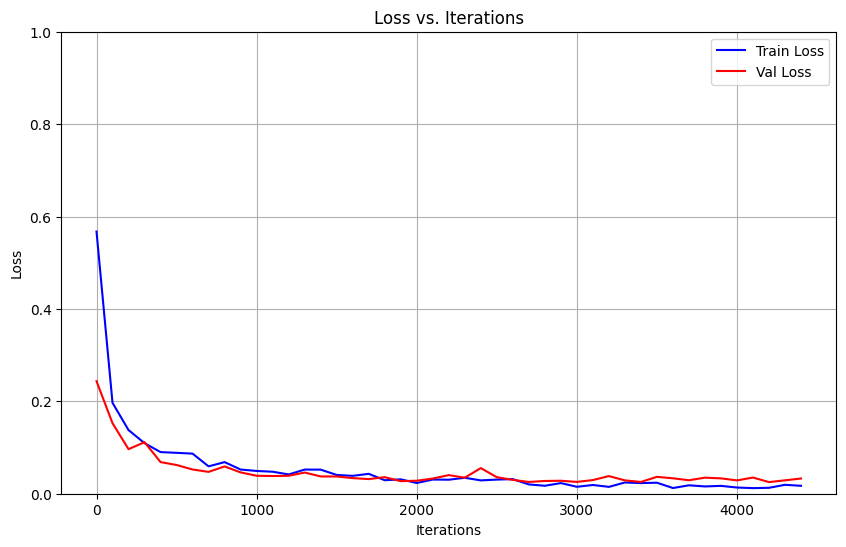

In [14]:
# Net5
print(f"Training Net5")
run_experiment(Net5, best_learning_rate, batch_size, best_optimizer)

Training FCN
Epoch [1/5], Step [100/938], Train Loss: 1.3370, Val Loss: 0.5423
Epoch [1/5], Step [200/938], Train Loss: 0.4310, Val Loss: 0.3628
Epoch [1/5], Step [300/938], Train Loss: 0.3657, Val Loss: 0.3113
Epoch [1/5], Step [400/938], Train Loss: 0.3082, Val Loss: 0.2827
Epoch [1/5], Step [500/938], Train Loss: 0.2989, Val Loss: 0.2703
Epoch [1/5], Step [600/938], Train Loss: 0.2532, Val Loss: 0.2512
Epoch [1/5], Step [700/938], Train Loss: 0.2501, Val Loss: 0.2315
Epoch [1/5], Step [800/938], Train Loss: 0.2500, Val Loss: 0.2142
Epoch [1/5], Step [900/938], Train Loss: 0.2129, Val Loss: 0.1964
Epoch [1/5] End. Duration: 20.50 seconds. Train Acc: 0.8924, Val Acc: 0.9425

Epoch [2/5], Step [100/938], Train Loss: 0.1859, Val Loss: 0.1797
Epoch [2/5], Step [200/938], Train Loss: 0.1874, Val Loss: 0.1941
Epoch [2/5], Step [300/938], Train Loss: 0.1962, Val Loss: 0.1653
Epoch [2/5], Step [400/938], Train Loss: 0.1599, Val Loss: 0.1601
Epoch [2/5], Step [500/938], Train Loss: 0.1585, Va

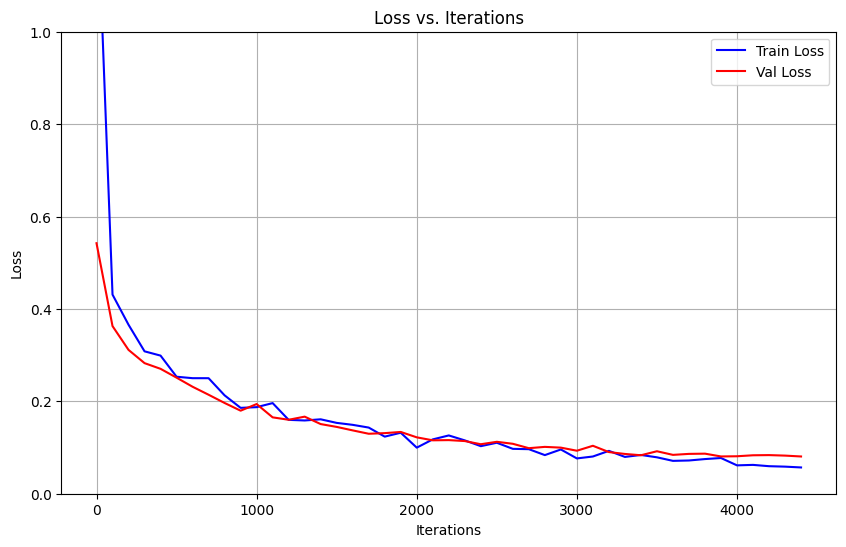

In [20]:
# FCN
print(f"Training FCN")
run_experiment(FCN, best_learning_rate, batch_size, best_optimizer)

#### ❓ **Q 5.7.4 Explain which model is better and why. Use your learning curves as well as what you know about model capacity to explain your reasoning.** If you think your results do not reflect the best model, explain which you expect to be best and why.

YOUR ANSWER HERE

#### ❓ **Q 5.7.5 Which model converges to a minimum faster? Why? What hyperparameters would you tune in order to get a model to converge faster?**

YOUR ANSWER HERE

#### ❓ **Q 5.7.6 Explain the purpose of the pooling layer**

YOUR ANSWER HERE

#### ❓ **Q 5.7.7  Is it possible for a model to have a smaller final loss, even if it has worse test accuracy.**

YOUR ANSWER HERE

#### ❓ **Q 5.7.8 Explain the difference between the CNN models and FCN.**

YOUR ANSWER HERE


---



### **5.8 Batch Normalization**

Choose the model that performs the best (`Net`, `Net2`, `Net5`, `FCN`). Add batch normalization layers where you see fit. Repeat and train and plot learning curves.



Epoch [1/5], Step [100/938], Train Loss: 0.2475, Val Loss: 0.1053
Epoch [1/5], Step [200/938], Train Loss: 0.1310, Val Loss: 0.1095
Epoch [1/5], Step [300/938], Train Loss: 0.0899, Val Loss: 0.0744
Epoch [1/5], Step [400/938], Train Loss: 0.0747, Val Loss: 0.0474
Epoch [1/5], Step [500/938], Train Loss: 0.0731, Val Loss: 0.0461
Epoch [1/5], Step [600/938], Train Loss: 0.0589, Val Loss: 0.0507
Epoch [1/5], Step [700/938], Train Loss: 0.0574, Val Loss: 0.0396
Epoch [1/5], Step [800/938], Train Loss: 0.0546, Val Loss: 0.0690
Epoch [1/5], Step [900/938], Train Loss: 0.0488, Val Loss: 0.0332
Epoch [1/5] End. Duration: 26.36 seconds. Train Acc: 0.9722, Val Acc: 0.9891

Epoch [2/5], Step [100/938], Train Loss: 0.0426, Val Loss: 0.0353
Epoch [2/5], Step [200/938], Train Loss: 0.0531, Val Loss: 0.0449
Epoch [2/5], Step [300/938], Train Loss: 0.0383, Val Loss: 0.0392
Epoch [2/5], Step [400/938], Train Loss: 0.0381, Val Loss: 0.0329
Epoch [2/5], Step [500/938], Train Loss: 0.0362, Val Loss: 0.034

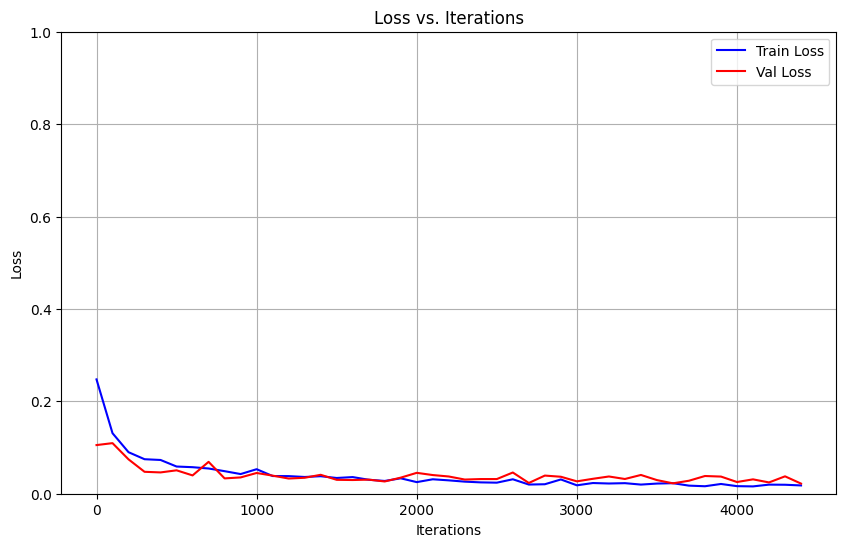

In [26]:
class Net5N(nn.Module):
    def __init__(self, input_size, num_classes):
      super(Net5N, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
      self.bn1 = nn.BatchNorm2d(32)
      self.relu = nn.ReLU()

      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
      self.bn2 = nn.BatchNorm2d(64)
      self.fc1 = nn.Linear(in_features=64*14*14, out_features=1024)
      self.bn3 = nn.BatchNorm1d(1024)
      self.fc2 = nn.Linear(in_features=1024, out_features=10)
    def forward(self, x):
      x = x.view(-1, 1, 28, 28)
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.pool(out)


      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)

      out = out.view(out.size(0), -1)

      out = self.fc1(out)
      out = self.bn3(out)
      out = self.relu(out)

      out = self.fc2(out)

      return out



run_experiment(Net5N, best_learning_rate, batch_size, best_optimizer)

#### ❓ **Q 5.8 Explain the purpose of the batch normalization layers,and how they affect training.**

YOUR ANSWER HERE

---
---

# End of Phase 1 😊🥳